# Project: Protein stability prediction

In the project you will try to predict protein stability changes upon point mutations. 
We will use acuumulated data from experimental databases, i.e. the Megascale dataset. A current [pre-print paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10402116/) has already preprocessed the dataset and created homology reduced data splits. We will reuse these. To do so, download the data folder from [here](https://polybox.ethz.ch/index.php/s/txvcb5jKy1A0TbY) and unzip it.  

The data includes measurements of changes in the Gibbs free enrgy ($\Delta \Delta G $). 
This will be the value that you will have to predict for a given protein with a point mutation. 
As input data you can use the protein sequence or a protein embedding retreived from ESM, a state of the art protein model.  

Here we will use the sequence as input. 
The model will predict the $\Delta \Delta G $ of point mutations in this sequence. To make training more efficient, the model should directly predict the values for all possible mutations at each position in the sequence. So the expected output is a sequence of $ L \ (sequence \ length) \ x \ 20 \ (number \ amino \ acids)$. This will be shown in detail later.

Below we provide you with a strcuture for the project that you can start with.  
Edit the cells to your liking and add more code to create your final model.


https://www.nature.com/articles/s41598-020-71450-8#Sec12

In [75]:
import os 
import numpy as np
import pandas as pd
import scipy
import sklearn.metrics as skmetrics

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import lightning as L

import torchmetrics
from torchmetrics.regression import PearsonCorrCoef

import torch.optim.lr_scheduler

In [76]:
aa_alphabet = 'ACDEFGHIKLMNPQRSTVWY' # amino acid alphabet
aa_to_int = {aa: i for i, aa in enumerate(aa_alphabet)} # mapping from amino acid to number

# function to one hot encode sequence
def one_hot_encode(sequence):
    # initialize a zero matrix of shape (len(sequence), len(amino_acids))
    one_hot = torch.zeros(len(sequence), len(aa_alphabet))
    if sequence != "0":
        for i, aa in enumerate(sequence):
            # set the column corresponding to the amino acid to 1
            one_hot[i].scatter_(0, torch.tensor([aa_to_int[aa]]), 1)
    return one_hot
    


# sequence data, comes already batched, so treat accordingly in dataloader (batch_size=1)
class SequenceData(Dataset):
    def __init__(self, csv_file, label_col="ddG_ML"):
        """
        Initializes the dataset. 
        input:
            csv_file: path to the relevant data file, eg. "/home/data/mega_train.csv"
        """
        
        self.min_size = 72
        
        self.df = pd.read_csv(csv_file, sep=",")
        self.label_col = label_col
        # only have mutation rows
        self.df = self.df[self.df.mut_type!="wt"]
        # process the mutation row
        self.df["mutation_pos"] = self.df["mut_type"].apply(lambda x: int(x[1:-1])-1) # make position start at zero
        self.df["mutation_to"] = self.df["mut_type"].apply(lambda x: aa_to_int[x[-1]]) # give numerical label to mutation

        # group by wild type
        self.df = self.df.groupby("WT_name").agg(list)
        # get wild type names
        self.wt_names = self.df.index.values
        # precompute one-hot encoding for faster training
        self.encoded_seqs = {}
        for wt_name in self.wt_names:
            # get the correct row
            mut_row = self.df.loc[wt_name]
            seq = mut_row["wt_seq"][0]
            self.encoded_seqs[wt_name] = one_hot_encode(seq)
            for i in range(self.min_size-len(self.encoded_seqs[wt_name])):
                #print(wt_name, i)
                self.encoded_seqs[wt_name] = torch.cat((self.encoded_seqs[wt_name], one_hot_encode("0")),0)
                

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get the wild type name
        wt_name = self.wt_names[idx]
        # get the correct row
        mut_row = self.df.loc[wt_name]
        # get the wt sequence in one hot encoding
        sequence_encoding = self.encoded_seqs[wt_name]

        # create mask and target tensors
        mask = torch.zeros((1, len(sequence_encoding),20)) # will be 1 where we have a measurement
        target = torch.zeros((1, len(sequence_encoding),20)) # ddg values
        # all mutations from df
        positions = torch.tensor(mut_row["mutation_pos"])
        amino_acids = torch.tensor(mut_row["mutation_to"])
        # get the labels
        labels = torch.tensor(mut_row[self.label_col])

        for i in range(len(sequence_encoding)):
            mask[0,i,amino_acids[positions==i]] = 1 # one where we have data
            target[0,i,amino_acids[positions==i]] = labels[positions==i] # fill with ddG values
        
        # returns encoded sequence, mask and target sequence 
     
        
        
        return {"sequence": sequence_encoding[None,:,:].float(), "mask": mask, "labels": target}

In [77]:
#go one directory up
def goOneUp():
    path_parent = os.path.dirname(os.getcwd())

    os.chdir(path_parent)
    os.getcwd()

In [78]:
#os.chdir("ProteinStabilityNN")
#goOneUp()
#os.getcwd()

In [79]:
# usage
dataset_train = SequenceData('project_data/project_data/mega_train.csv')
dataset_val= SequenceData('project_data/project_data/mega_val.csv')
dataset_test = SequenceData('project_data/project_data/mega_test.csv')

# use batch_size=1 bc we treat each sequence as one batch
dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=False, num_workers=16)
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True, num_workers=16)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=16)

In [80]:
dataset_train.df["wt_seq"]

WT_name
1A32.pdb       [SPEVQIAILTEQINNLNEHLRVHKKDHHSRRGLLKMVGKRRRLLA...
1AOY.pdb       [QEELVKAFKALLKEEKFSSQGEIVAALQEQGFDNINQSKVSRMLT...
1E0L.pdb       [GATAVSEWTEYKTADGKTYYYNNRTLESTWEKPQELK, GATAVS...
1E6H.pdb       [DETGKELVLVLYDYQEKSPREVTIKKGDILTLLNSTNKDWWKIEV...
1ENH.pdb       [AFSSEQLARLKREFNENRYLTERRRQQLSSELGLNEAQIKIWFQN...
                                     ...                        
v2_2HDZ.pdb    [AEEIWQQSVIGDYLARFKNDRVKALKAMEMTWNNMEKKEKLMWIK...
v2_2LXE.pdb    [VLKALERTRQLDIPDEKTMPVLMKLLEEAGGNWSYIKLDNYTALV...
v2_2M5A.pdb    [VDNKFNKEQQNAFYEILHLPNLNEEQRNAFIQSLKDDPSQSANLL...
v2_4UZX.pdb    [SPEEIKAKALDLLNKKLHRANKFGQDQADIDSLQRQINRVEKFGV...
v2_6IVS.pdb    [NRLGIIYEIQGMKAVVLTSEGEFLIIRRRKDMKVGQQVSFENEDI...
Name: wt_seq, Length: 239, dtype: object

In [81]:
dataset_train.encoded_seqs['1A32.pdb'].shape

torch.Size([72, 20])

In [82]:
dataset_train.__getitem__(4)["label"]

KeyError: 'label'

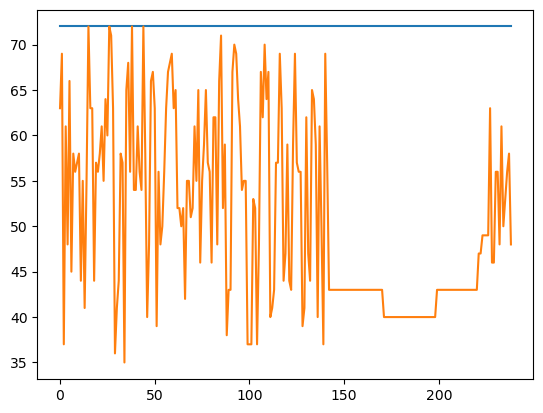

In [83]:

plt.plot([len(dataset_train.encoded_seqs[seq]) for seq in dataset_train.encoded_seqs.keys()])
#max([len(dataset_train.encoded_seqs['1A32.pdb']) for seq in range(len(dataset_train.encoded_seqs))])
    
plt.plot([len(dataset_train.df["aa_seq"][seq][0]) for seq in range(len(dataset_train.df))])
#max([len(dataset_train.df["aa_seq"][seq][0]) for seq in range(len(dataset_train.df))])
    

In [84]:
batch = next(iter(dataloader_train))

In [85]:
#Model architecture and training¶

In [86]:
# get the output shape of our data after a convolution and pooling of a certain size

def get_conv2d_out_shape(tensor_shape, conv, pool=2):
    # return the new shape of the tensor after a convolution and pooling
    # tensor_shape: (channels, height, width)
    # convolution arguments
    kernel_size = conv.kernel_size
    stride=conv.stride # 2D array
    padding=conv.padding # 2D array
    dilation=conv.dilation # 2D array
    out_channels = conv.out_channels

    height_out = np.floor((tensor_shape[1]+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    width_out = np.floor((tensor_shape[2]+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)
    
    if pool:
        # adjust dimensions to pooling
        height_out/=pool
        width_out/=pool
        
    return int(out_channels),int(height_out),int(width_out)

In [87]:
#initial size 293*72*20
initial_depth = 1
channels_in = 1
fc1 = 7
get_conv2d_out_shape([293,72,20], nn.Conv2d(channels_in, initial_depth, kernel_size=3), pool=2)
# layer 1 and pool (1, 35, 9)
get_conv2d_out_shape([1, 35, 9], nn.Conv2d(channels_in, initial_depth, kernel_size=4), pool=0)
# layer 2 without pool (1, 32, 6)
#1*32*6=192
# layer fc1 1*192 -- 1*7
# layer fc2 1*7 -- 1*1


(1, 32, 6)

In [295]:
class convModel(nn.Module):
    
    # Network Initialisation
    def __init__(self, params):
        
        super(convModel, self).__init__() #initialize parent pytorch module

        # read parameters
        shape_in = params["shape_in"]
        kernelSize = params["kernelSize"]
        
        self.dropout = nn.Dropout(0.3)
        self.pool = nn.AvgPool2d(2, 2)
        #channels_out = params["initial_depth"] 
        #fc1_size = params["fc1_size"]
        
        #### Convolution Layers

        # Max pooling layer        

        ##conv layer 1
        # convolution with kernel size 8, goes from three channels to 
        # number defined by initial_depth in params
        self.conv1 = nn.Conv2d(shape_in[0], 15, kernel_size=kernelSize[0], padding=int((kernelSize[0]-1)/2), padding_mode='zeros')
        
        current_data_shape = get_conv2d_out_shape(shape_in, self.conv1, pool=2)
        #shape in = (3, 256, 256)
        self.conv2 = nn.Conv2d(15, shape_in[0], kernel_size=kernelSize[1], padding=int((kernelSize[1]-1)/2), padding_mode='zeros')
        #####################################
        

    def forward(self,X):
        # our network's forward pass
        
        # Convolution & Pool Layers
        ############# TODO ###############
        # convolution (conv1), then relu, then max pool 
        X = F.sigmoid(self.conv1(X)) #leaky_relu 1.119, tanh 1.5926 (only positive values), sigmoid 1.2797 (only positive values?) RMSE
        X = self.dropout(X)
        X = self.pool(X)
        X = F.interpolate(X, 20)
        X.to(device = "cuda")
        
        X = X.permute(0, 2, 1)
        X.to(device = "cuda")
        X = F.interpolate(X, 72)
        X.to(device = "cuda")
        X = X.permute(0, 2, 1)
        X.to(device = "cuda")
        # convolution (conv2), then relu, then max pool (best model until now 2 layers conv, dropout 0.4, 1, 15, 7; 15. 
        X = self.conv2(X)

        #####################################
        # return log softmax to fit classification problem, no relu needed
        return X

In [296]:
'''
# take first batch from the train loader
batch = next(iter(dataloader_train))
print(batch["sequence"][0].shape)
# create the model
cnn_model = convModel(params={"shape_in":batch["sequence"][0].shape,"initial_depth":1,"fc1_size":32})#default values
# forward pass
out = cnn_model(batch)
# print shape of the input batch
print("Shape of the input batch: ", batch.shape)
# print the output shape
print("Shape of the output: ", out.shape)
# prediction output for first image, exp to get from log back to probabilities
print(torch.exp(out[0].detach()))
'''

'\n# take first batch from the train loader\nbatch = next(iter(dataloader_train))\nprint(batch["sequence"][0].shape)\n# create the model\ncnn_model = convModel(params={"shape_in":batch["sequence"][0].shape,"initial_depth":1,"fc1_size":32})#default values\n# forward pass\nout = cnn_model(batch)\n# print shape of the input batch\nprint("Shape of the input batch: ", batch.shape)\n# print the output shape\nprint("Shape of the output: ", out.shape)\n# prediction output for first image, exp to get from log back to probabilities\nprint(torch.exp(out[0].detach()))\n'

In [297]:
batch["sequence"][0][0][15]

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [298]:
batch["mask"][0][0][15]

tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1.])

In [299]:
batch["labels"][0][0][15]

tensor([-1.6658, -1.4547, -2.3814, -2.0729,  0.0000, -2.3535, -1.6088, -1.5041,
        -2.1131, -1.3123, -1.4804, -2.3868,  0.0000, -1.8227, -1.5626, -1.6090,
        -2.0565, -1.7244, -0.0301, -0.0326])

In [300]:
class LitMRIModel(L.LightningModule):
    def __init__(self, model, learning_rate=1e-3):
        super().__init__()
        ######## TODO ##########
        # pass our model 
        self.model = model
        #pass the learning rate
        self.lr = learning_rate
        # define loss function
        self.loss_function = nn.MSELoss() #TODO
        # define accuracy metric (torchmetrics)
        #self.accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=2)
        ########################

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        ######### TODO #############
        
        # read from batch
        # TODO
        x = batch["sequence"][0]
        mask = batch["mask"][0]
        y = batch["labels"][0]
        #print(x)
        #print(y)
        # run data through model
        predictions = self.model(x)
        # compute loss
        # 1 prediction
        loss = self.loss_function(predictions[mask==1], y[mask==1])
        #loss = self.loss_function(predictions, y)
        # compute accuracy
        #acc = self.accuracy(predictions, y)
        
        #sch = self.lr_schedulers()

        # step every N epochs
        #if self.trainer.is_last_batch and (self.trainer.current_epoch + 1) % 3 == 0:
        #    sch.step()
        ##############################

        # logging the values (will appear in progress bar and on dashboard)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        #self.log("train_acc", acc, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        ############## TODO ################
        # define the optimizer, let's use Adam
        #optimizer = optim.SGD([torch.rand((2,2), requires_grad=True)], lr=0.1)
        #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        ####################################
        return optimizer

    def test_step(self, batch, batch_idx):
        # this is the test loop

        ############### TODO #############accumulate_grad_batches=7
        # read from batch
        x = batch["sequence"][0]
        mask = batch["mask"][0]
        y = batch["labels"][0]

        # run data through model
        predictions = self.model(x)
        
        # compute loss
        #loss = loss(prediction,labels[mask==1])
        loss = self.loss_function(predictions[mask==1], y[mask==1])
        # compute accuracy
        #acc = self.accuracy(predictions, y)
        ##############################

        # logging
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        return loss#, acc


    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        ############### TODO #############
        # read from batch
        x = batch["mask"][0]
        mask = batch["mask"][0]
        y = batch["labels"][0]

        #print(x.shape)
        #print(y.shape)
        # run data through model
        predictions = self.model(x)
        #print(predictions.shape)
        # compute loss
        loss = self.loss_function(predictions[mask==1], y[mask==1])
        #loss = self.loss_function(predictions, y)
        # compute accuracy
        #acc = self.accuracy(predictions, y)#torchmetrics.classification.Accuracy(task="MULTICLASS", num_classes=2)
        ##############################

        # logging
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        #self.log("val_acc", acc, on_epoch=True, prog_bar=True)
        return loss 

In [301]:
from lightning.pytorch.callbacks import LearningRateFinder

class FineTuneLearningRateFinder(LearningRateFinder):
    def __init__(self, milestones, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.milestones = milestones

    def on_fit_start(self, *args, **kwargs):
        return

    def on_train_epoch_start(self, trainer, pl_module):
        if trainer.current_epoch in self.milestones or trainer.current_epoch == 0:
            self.lr_find(trainer, pl_module)



In [302]:
batch["sequence"][0].shape[0]

1

In [303]:
# define parameters
params_model={
    "shape_in": batch["sequence"][0].shape,
    "kernelSize": (7, 15)
    }

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Instantiate the model
cnn_model = convModel(params_model)
# moves the model to GPU if available
cnn_model = cnn_model.to(device)

In [304]:
batch

{'sequence': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [1., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'mask': tensor([[[[1., 0., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [0., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'labels': tensor([[[[ 0.3369,  0.0000,  0.5479,  ...,  0.3026,  0.0036,  0.2169],
           [-0.1237,  0.5924,  0.2935,  ...,  0.1751,  0.1305,  0.2083],
           [ 0.0000,  0.6616,  0.1659,  ...,  0.1461,  0.3610,  0.3515],
           ...,
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.

In [305]:
# train model
########## TODO #############
# instantiate lightning model with the cnn_model and learning_rate=1e-3
model = LitMRIModel(cnn_model, learning_rate=1e-3)
############################

# instantiate the lightning trainer 
trainer = L.Trainer(max_epochs=30, log_every_n_steps=10)#, accumulate_grad_batches=3)#, callbacks=[FineTuneLearningRateFinder(milestones=(5, 10))])
# train
trainer.fit(model, dataloader_train, dataloader_val)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type      | Params
--------------------------------------------
0 | model         | convModel | 4.1 K 
1 | loss_function | MSELoss   | 0     
--------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.017     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [114]:
# Test the model on the validation set
trainer.validate(model, dataloader_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |                                             | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.8657399415969849
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.8657399415969849}]

RMSE: 0.8833433
Pearson r: PearsonRResult(statistic=0.3013380869967247, pvalue=0.0)
Spearman r: SignificanceResult(statistic=0.2785734221210745, pvalue=0.0)


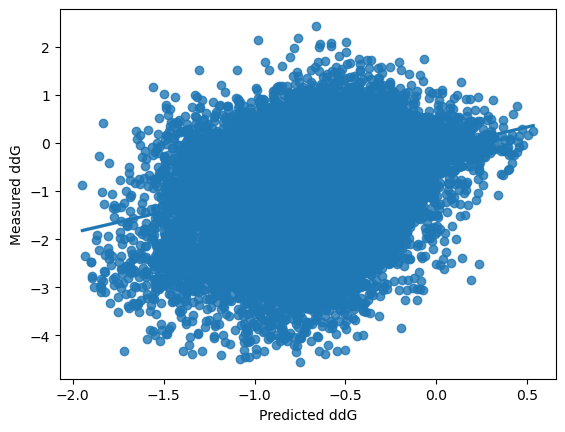

In [115]:
preds =[]
all_y = []

for batch in dataloader_val:
    # read from batch
    x = batch["sequence"][0]
    mask = batch["mask"][0]
    target = batch["labels"][0]
    ## adjust to work with your model
    # predict
    prediction = cnn_model(x)
    preds.append(prediction[mask==1].flatten().detach().numpy()) # flatten to create one dimensional vector from 2D sequence
    all_y.append(target[mask==1].flatten().detach().numpy()) # flatten to create one dimensional vector from 2D sequence

# concatenate and plot
preds= np.concatenate(preds)
all_y = np.concatenate(all_y)

sns.regplot(x=preds,y=all_y)
plt.xlabel("Predicted ddG")
plt.ylabel("Measured ddG")

# get RMSE, Pearson and Spearman correlation 
print("RMSE:", skmetrics.mean_squared_error(all_y, preds, squared=False))
print("Pearson r:", scipy.stats.pearsonr(preds, all_y))
print("Spearman r:", scipy.stats.spearmanr(preds, all_y))

In [67]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

In [306]:
def custom_viz(kernels, path=None, cols=None):



    N = kernels.shape[0]
    C = kernels.shape[1]

    Tot = N*C

    # If single channel kernel with HxW size,# plot them in a row.# Else, plot image with C number of columns.
    if C>1:
        columns = C
    elif cols==None:
        columns = N
    elif cols:
        columns = cols
    rows = Tot // columns 
    rows += Tot % columns

    pos = range(1,Tot + 1)

    fig = plt.figure(1)
    fig.tight_layout()
    k=0 
    for i in range(kernels.shape[0]):
        for j in range(kernels.shape[1]):
            img = kernels[i][j]
            ax = fig.add_subplot(rows,columns,pos[k])
            ax.imshow(img, cmap='YlGnBu')
            plt.axis('off')
            k = k+1

    set_size(30,30,ax)
    if path:
        plt.savefig(path, dpi=100)

    plt.show()

In [307]:
def set_size(w,h, ax=None):
    if not ax: 
        ax=plt.gca()
        l = ax.figure.subplotpars.left
        r = ax.figure.subplotpars.right
        t = ax.figure.subplotpars.top
        b = ax.figure.subplotpars.bottom
        figw = float(w)/(r-l)
        figh = float(h)/(t-b)
        ax.figure.set_size_inches(figw, figh)

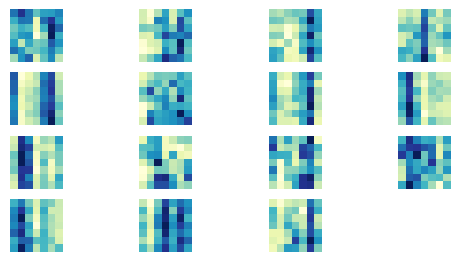

In [308]:
kernels = cnn_model.conv1.weight.cpu().detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
custom_viz(kernels, cols=4)


In [309]:
batch = next(iter(dataloader_train))


In [310]:
dataset_train.df.loc["1A32.pdb"]["wt_seq"][0][0]

'S'

In [312]:
a=[dataset_train.df.loc["1A32.pdb"]["wt_seq"][0][0]]
a=a+[mut[-1] for mut in dataset_train.df.loc["1A32.pdb"]["mut_type"]][0:19]
a=''.join(a)

In [313]:
a

'SQENHDRKTAGMLVIWYFPC'

In [314]:
dataset_train.df.loc["1A32.pdb"]["wt_seq"][0][21]

'V'

In [344]:
averageLabels = np.zeros(batch["labels"][0].squeeze(0).numpy().shape)

for batch in dataloader_val:
    averageLabels += batch["labels"][0].squeeze(0).numpy()
    
averageLabels /= len(dataloader_val)

In [345]:
averagePreds = np.zeros(batch["labels"][0].squeeze(0).numpy().shape)

for batch in dataloader_val:
    averagePreds += cnn_model(batch["sequence"][0]).squeeze().detach().numpy()
    
averagePreds /= len(dataloader_val)

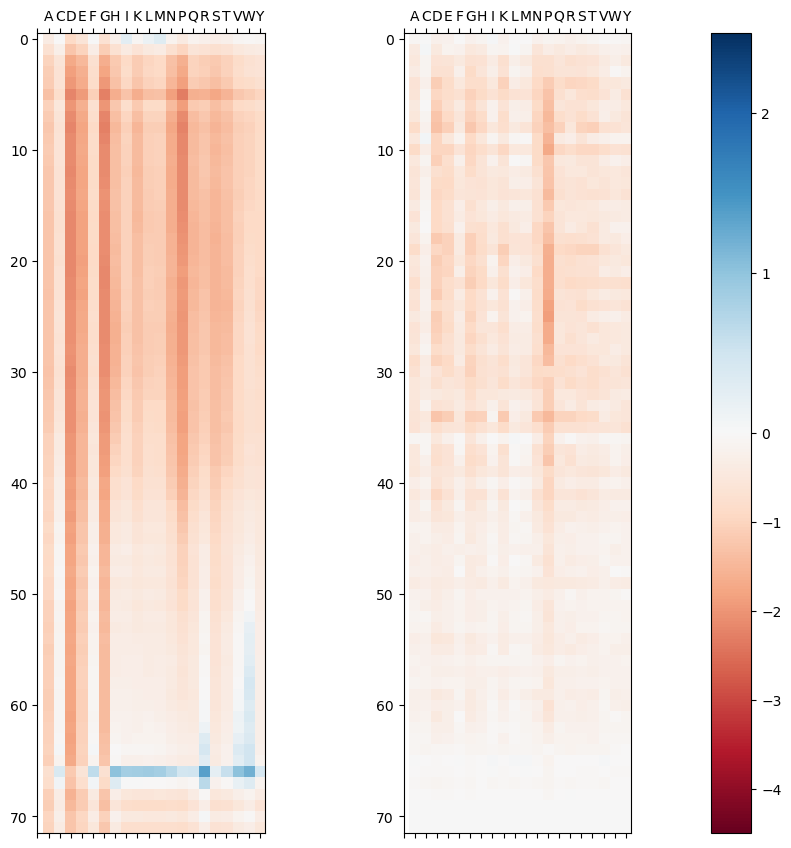

In [346]:
from matplotlib import colors
aa_alphabet = 'ACDEFGHIKLMNPQRSTVWY'

my_xticks = [char for char in aa_alphabet]

fig = plt.figure()
ax = fig.add_subplot(111)
divnorm=colors.TwoSlopeNorm(vmin=-4.5, vcenter=0., vmax=2.5)
cax = ax.matshow(averageLabels, cmap='RdBu', norm=divnorm)
fig.colorbar(cax)

xaxis = np.arange(len(my_xticks)+1)
ax.set_xticks(xaxis-1)
ax.set_xticklabels(['']+my_xticks)

ax2 = fig.add_subplot(111)
divnorm2=colors.TwoSlopeNorm(vmin=-2, vcenter=0., vmax=0.5)
cax = ax2.matshow(averagePreds, cmap='RdBu', norm=divnorm2)


xaxis = np.arange(len(my_xticks)+1)
ax2.set_xticks(xaxis-1)
ax2.set_xticklabels(['']+my_xticks)

set_size(16,8)

plt.show()
#plt.xticks(x, my_xticks)

#plt.show()

In [260]:
cnn_model(batch["sequence"][0].cuda()).cpu().squeeze().detach().numpy().shape

(72, 20)

In [330]:
np.mean(batch["labels"][0].squeeze(0).numpy())

-0.5257345

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [328]:
np.mean(batch["labels"][0].squeeze(0).numpy(), axis=0)

array([-0.31928894, -0.25357363, -0.94984204, -0.6442225 , -0.38477775,
       -0.8889915 , -0.54051524, -0.20544249, -0.4716594 , -0.1238289 ,
       -0.18036279, -0.7292871 , -1.5089812 , -0.49874306, -0.4806024 ,
       -0.5886403 , -0.51826274, -0.31659743, -0.44025487, -0.47081456],
      dtype=float32)

In [ ]:
from matplotlib import colors

my_xticks = [char for char in aa_alphabet]

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
langs = ['C', 'C++', 'Java', 'Python', 'PHP']
students = [23,17,35,29,12]
ax.bar(langs,students)